## Sedaro Validaton Notebook
### Orbit Propagation

This validation notebook covers the Sedaro orbit propagator. We will compare results from a public Sedaro scenario to a reference propagator and visualize the resulting errors. Reference values for this validation are derived from the NASA General Mission Analysis Tool (GMAT), Version R2022a.

> GMAT is a software system for space mission design, navigation, and optimization applicable to missions anywhere in the solar system ranging from low Earth orbit to lunar, Libration point, and deep space missions. The system contains high-fidelity space system models, optimization and targeting, built-in scripting and programming infrastructure, and customizable plots, reports and data products that enable flexible analysis and solutions for custom and unique applications. GMAT can be driven from a fully featured, interactive Graphical User Interface (GUI) or from a custom script language.

For more information about the reference tool, visit the links below.

- https://opensource.gsfc.nasa.gov/projects/GMAT/index.php
- https://sourceforge.net/projects/gmat/files/GMAT/GMAT-R2022a/

### Reproducing our Results

To ensure reproducibility, the directory containing this notebook also includes a file that specifies the exact package versions that were used. See the README for steps on setting up your environment.

Confirm that the Jupyter notebook is using this virtual evironment before running the code below.

In [1]:
import json
import urllib.request
import zipfile
import numpy as np

from pathlib import Path
from astropy.time import Time
from oem import OrbitEphemerisMessage
from sedaro import SedaroApiClient
from utils import progress_bar, plot_results

### Important: Read Before Running

This notebook requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the root directory of this repository (two levels above this notebook) with the following format:
```json
{
    "API_KEY": "<API_KEY>"
}
```
API keys grant full access to your repositories and should never be shared. If you think your API key has been compromised, you can revoke it in the user settings interface on the Sedaro website.

In [2]:
with open('../../secrets.json', 'r') as file:
    API_KEY = json.load(file)['API_KEY']

## Download Scenario Data

This notebook considers the following reference scenario:
- [Orbit Validation Scenario](https://satellite.sedaro.com/#/scenario/PLCPJHKtysym8fHJVxslm3/edit)

The code below will pull the latest simulation results from the live Sedaro site.

In [3]:
# This is the ID of the scenario branch in the Sedaro shared workspace.
SCENARIO_BRANCH_ID = 'PLCPJHKtysym8fHJVxslm3'

sedaro = SedaroApiClient(API_KEY)
sim = sedaro.scenario(SCENARIO_BRANCH_ID).simulation

In [4]:
# This value can be changed to reduce the sampling of the plots below without
# affecting the validity of the results.
sample_rate = 32
results = sim.results(sampleRate=sample_rate)

## Download Reference Data


In [5]:
# Data is ~120 MiB, so it is stored outside of the git repository.
# Total uncompressed volume is approximately 325 MiB.
url = 'https://sedaro-modsim-artifacts.s3.us-gov-east-1.amazonaws.com/orbit_validation_ephemerides.zip'
ref_data_path = Path('reference_data')
if not len(tuple(ref_data_path.glob('*.oem'))):
    ref_data_path.mkdir(exist_ok=True)
    ref_data_archive = ref_data_path / 'reference_data.zip'

    if not ref_data_archive.exists():
        print('Downloading reference data...', end='')
        urllib.request.urlretrieve(url, ref_data_archive)
        print('done!')

    with zipfile.ZipFile(ref_data_archive, 'r') as archive:
        print('Extracting reference data...', end='')
        archive.extractall(ref_data_path)
        print('done!')

Extracting reference data...done!


## Process Data

In this section, we will calculate comparison metrics between the GMAT ephemerides in the `reference_data` directory and the data pulled from the Sedaro scenario. The code below iterates through the agents in the Sedaro scenario, loads the corresponding ephemeris produced by GMAT, and samples a number of points between the start and end time of the simulation to compare.

In [6]:
print("Calculating comparison metrics. This may take a while...")
progress_bar(0)
data = {}
all_agents = set(results.peripheral_agents + results.templated_agents)
for idx, agent_name in enumerate(all_agents):
    agent = results.agent(agent_name).block('root')
    oem = OrbitEphemerisMessage.open(f'reference_data/{agent_name}_ephem.oem')

    data[agent_name] = {'error': [], 'elapsed_hours': []}
    for mjd, elapsed_time, position in agent.position.eci:
        t = Time(mjd, format='mjd', scale='utc')
        reference = oem(t).position
        data[agent_name]['error'].append(1000 * np.linalg.norm(position - reference))
        data[agent_name]['elapsed_hours'].append(elapsed_time / 3600)

    progress_bar(100 * (idx + 1) / len(all_agents))

Calculating comparison metrics. This may take a while...


## Visualize Results

This section presents the error metrics calculated above, separating agents by orbital regime.

The GMAT model has been configured to match as closely as possible to the Sedaro propagator, however there are some anticipated differences:

- GMAT uses a constant Earth gravity model degree and order of 40/40, but Sedaro uses a linearly-decreasing configuration. Both use the EGM-2008 coefficients.
- GMAT uses DE421 for planetary ephemerides by default while Sedaro uses DE440.
- Sedaro makes long-term assumptions about Earth Orientation Parameters while GMAT uses more recent data. GMAT has not been updated from its default deployment, so it is using its default EOP prediction coefficients.
- The two tools use different techniques for integrating the differential equations, though the difference in accuracy is expected to be small.
- Sedaro uses a standard atmosphere model that GMAT does not support. A higher-fidelity replacement for this model in Sedaro is in active development.

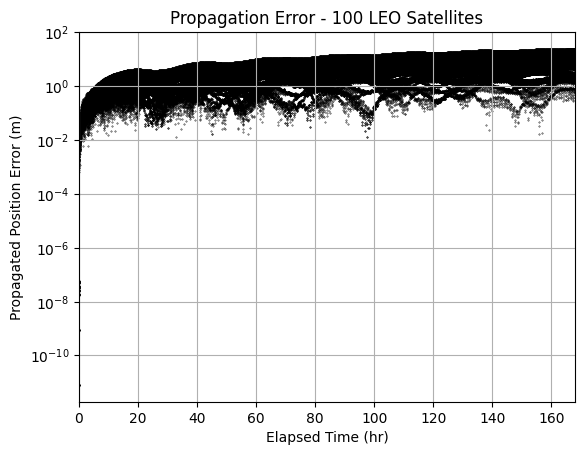

In [7]:
# Circular LEO, no drag / SRP
plot_results(data, 'leo_circular', 'LEO Satellites')

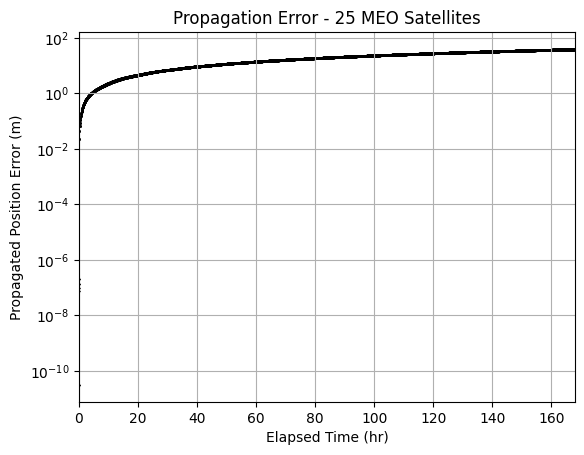

In [8]:
# Circular MEO, no drag / SRP
plot_results(data, 'meo_circular', 'MEO Satellites')

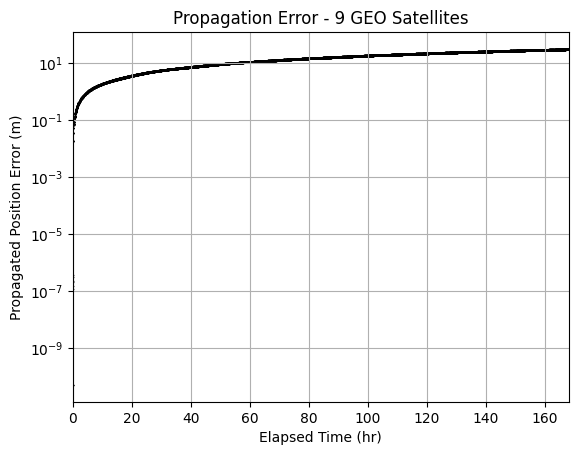

In [9]:
# Circular GEO, no drag / SRP
plot_results(data, 'geo_circular', 'GEO Satellites')

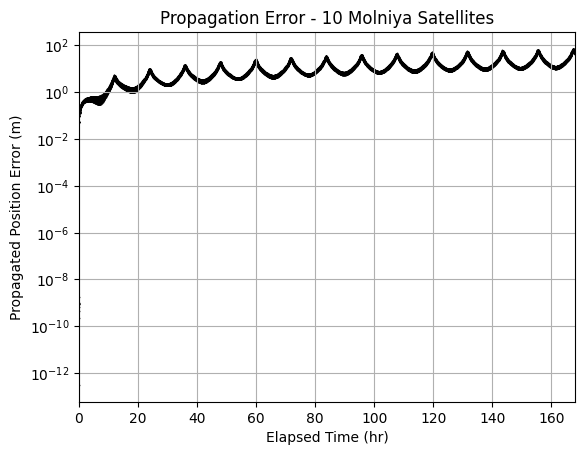

In [10]:
# Molniya, no drag / SRP
plot_results(data, 'molniya', 'Molniya Satellites')

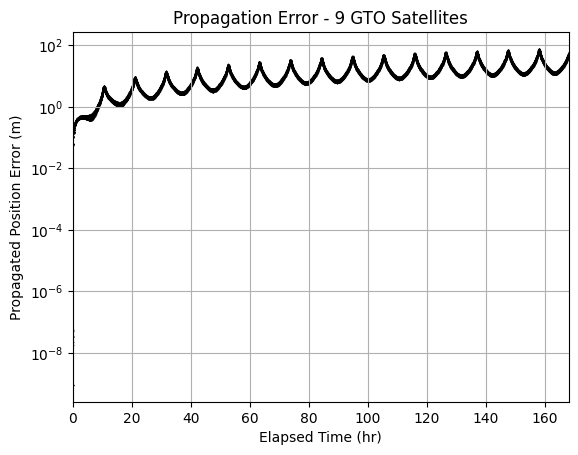

In [11]:
# GTO, no drag / SRP
plot_results(data, 'geo_transfer', 'GTO Satellites')

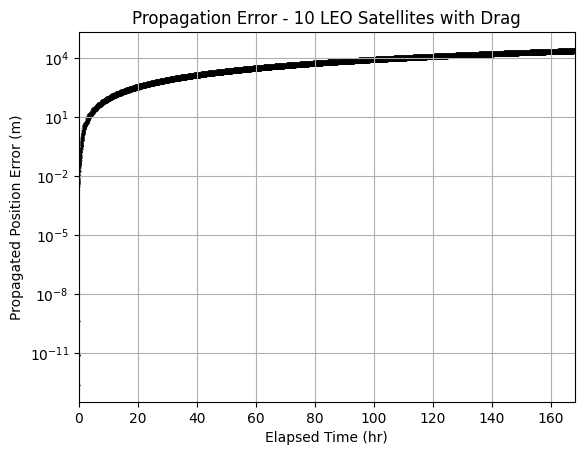

In [12]:
# Circular LEO, with drag
# The next version of Sedaro will include the MSISE atmosphere model and
# should significantly improve the accuracy of the drag calculations.
plot_results(data, 'leo_circular_drag', 'LEO Satellites with Drag')

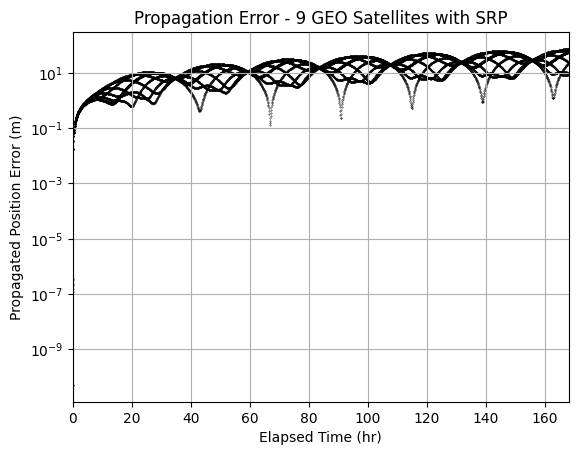

In [13]:
# Circular GEO, with SRP
plot_results(data, 'geo_circular_srp', 'GEO Satellites with SRP')

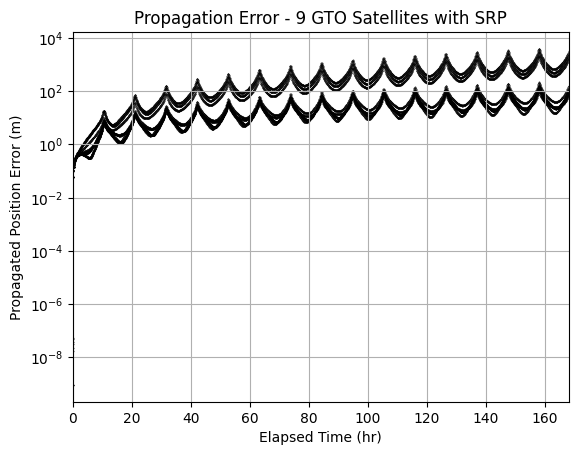

In [14]:
# GTO, with SRP
plot_results(data, 'geo_transfer_srp', 'GTO Satellites with SRP')

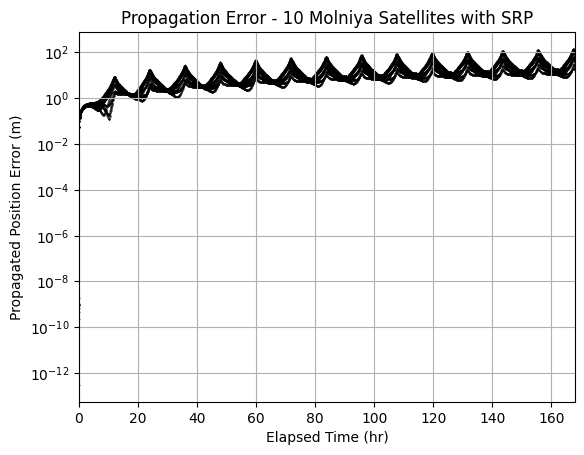

In [15]:
# Molniya, with SRP
plot_results(data, 'molniya_srp', 'Molniya Satellites with SRP')